## Convolution Autoencoder

- Mnist dataset
- Convolutional Neural Network
- 2 hidden layers

### 1. Settings

#### 1) Import required libraries

In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

#### 2) Set hyperparameters

In [2]:
batch_size = 100
learning_rate = 0.002
num_epoch = 1

### 2. Data

#### 1) Download data

In [3]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

#### 2) Set DataLoader

In [4]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size = batch_size, shuffle = True, num_workers = 2, drop_last = True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size = batch_size, shuffle = True, num_workers = 2, drop_last = True)

### 3. Model & Optimizer

#### 1) Model

In [16]:
#일반적인 CNN 모델
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),
                        # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,padding=1),
                        # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),
                        # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)
                        # batch x 64 x 14 x 14
        )
        
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),
                        # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),
                        # batch x 64 x 7 x 7
                        nn.ReLU()
            )
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
            
        return out

encoder = Encoder().cuda()      #Gpu로 돌리기 위해서       

In [17]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        #input channel, output channel, kernal size, stride, padding, output_padding
                        #padding은 ouput에 대해 가장자리를 자른다.
                        #output padding은 output에 대해 가장자리 padding을 붙인다.
                        #input에 대해 2배가 늘어남
                        #batch,128,14,14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        #batch,64,14,14
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,16,3,1,1),
                        # batch,16,14,14
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,1,3,2,1,1),
                        # batch,1,28,28
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,7,7)
        out = self.layer1(out)
        out = self.layer2(out)
            
        return out

decoder = Decoder().cuda() #gpu로 돌리기 위해서
            

#### 2) Loss function & Optimizer

In [18]:
#파라미터가 encoder도 있고 decoder도 있기 때문에 전체를 학습시켜 주기 위해서
parameters = list(encoder.parameters()) + list(decoder.parameters())
loss_func = nn.MSELoss()

optimizer = torch.optim.Adam(parameters, lr = learning_rate)

### 4. Train

In [19]:
try:
    encoder, decoder = torch.load('./model/conv_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

for i in range(num_epoch):
    for j, [image,label] in enumerate(train_loader):
        # 어차피 label 안 쓸꺼긴 함.
        optimizer.zero_grad()
        
        image = Variable(image).cuda() #gpu를 사용하기 위해서
        output = encoder(image)
        output = decoder(output)
        
        loss = loss_func(output,image)
        
        loss.backward()
        optimizer.step()
        
    if j % 10 == 0:
        torch.save([encoder,decoder],'./model/conv_autoencoder.pkl')
        print(loss)


--------model not restored--------



### 5. Check with Train Image

torch.Size([100, 28, 28])


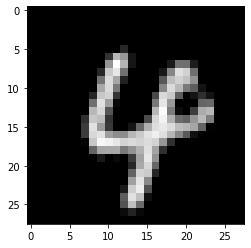

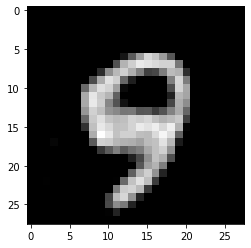

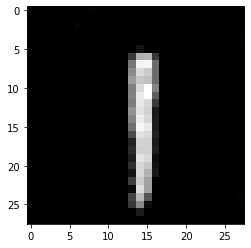

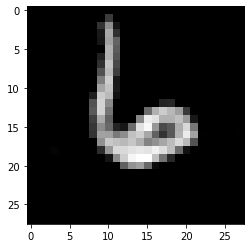

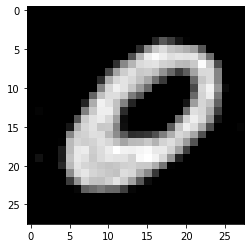

In [20]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    #plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    #plt.show()
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()